## ミラーレスカメラ（ソニーα7-III)のRAW現像

### この節について

この節ではこれまで扱ってきた処理を使ってソニーα7-IIIのRAW画像を現像してみます。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](http://bit.ly/raw_toc)から参照するか、以下のリンクを使ってアクセスしてください。

http://bit.ly/raw_chap_6_3

### 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。内容については各節を参照ください。

In [0]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロードとインポート
!if [ ! -f raw_process.py ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi
from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction
from raw_process import demosaic, defect_correction, color_correction_matrix, lens_shading_correction
from raw_process import noise_filter, apply_matrix, edge_enhancement, tone_curve_correction, advanced_demosaic

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'

In [0]:
# もし日本語が文字化けしている場合以下の３行の行頭の#を削除して実行後、
# import matplotlib
# target_dir = matplotlib.get_cachedir()
# ! rm {target_dir}/*.json
# その後Runtime->Restart Runtime選択してページ全体を再実行

今回はソニーα7 IIIのRAW画像を使用します。よみこんでみましょう。

In [0]:
# 画像をダウンロードします。
!if [ ! -f sample.ARW ]; then wget http://bit.ly/raw_sample_arw -O sample.ARW; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "sample.ARW"
raw = rawpy.imread(raw_file)

exiftoolを使ってRAWファイルの情報を見てみましょう。

In [0]:
! apt install exiftool

In [5]:
! exiftool sample.ARW

ExifTool Version Number         : 10.80
File Name                       : sample.ARW
Directory                       : .
File Size                       : 24 MB
File Modification Date/Time     : 2019:03:10 17:47:04+00:00
File Access Date/Time           : 2019:03:10 17:47:04+00:00
File Inode Change Date/Time     : 2019:03:10 17:47:04+00:00
File Permissions                : rw-r--r--
File Type                       : ARW
File Type Extension             : arw
MIME Type                       : image/x-sony-arw
Exif Byte Order                 : Little-endian (Intel, II)
Image Description               : 
Orientation                     : Horizontal (normal)
Image Width                     : 6048
Image Height                    : 4024
Bits Per Sample                 : 14
Compression                     : Sony ARW Compressed
Photometric Interpretation      : Color Filter Array
Samples Per Pixel               : 1
Planar Configuration            : Chunky
X Resolution                    : 350
Y 

沢山の情報が得られます。

まず、次の行から1画素が14ビットなことがわかります。
> Bits Per Sample                 : 14


ブラックレベルは512です。
> Black Level                     : 512 512 512 512

また、次の行からホワイトレベル（白をしめす基準値）が15360な事がわかります。
> White Level                     : 15360 15360 15360

さらに、次の行からカラーマトリクスの値も得られます。1024で正規化されているようです。
> Color Matrix                    : 1141 -205 88 -52 1229 -154 70 -225 1179


RAWPYの機能を使って最終的な画像を見ておきましょう。

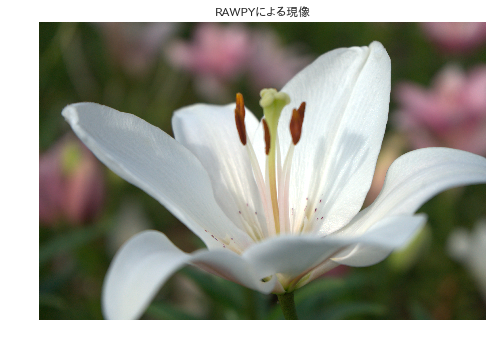

In [6]:
# RAWPYの機能で現像処理。
# use_camera_wbはホワイトバランスにカメラの値を使う指定。
rgb = raw.postprocess(use_camera_wb=True)
plt.title("RAWPYによる現像")
plt.imshow(rgb)
plt.axis('off')
plt.show()

RAWデータの情報を見てみましょう。

In [7]:
print(raw.sizes)

ImageSizes(raw_height=4024, raw_width=6048, height=4024, width=6024, top_margin=0, left_margin=0, iheight=4024, iwidth=6024, pixel_aspect=1.0, flip=0)


画像サイズは6024x4024のようです。24M画素でラズベリーパイの画像の約3倍です。

Bayerパターンを確認しましょう。

In [8]:
print(raw.raw_pattern)

[[0 1]
 [1 2]]


左上が赤、右下が青、というそれ以外が緑というパターンのようです。これはEXIFのCFA Pattern (0 1 1 2)と一致しています。

ホワイトバランスを確認します。

In [9]:
print(raw.camera_whitebalance)

[2288.0, 1024.0, 1544.0, 1024.0]


これはEXIFのWB RGGB Levels Autoと同じ値です。またラズベリーパイと違って1倍を1024であらわしているようです。

それではRAW現像に入りましょう。

RAW画像データをNumpy配列に読み込みます。

In [0]:
raw_array = raw.raw_image
h, w = raw_array.shape

それでは処理を行いましょう。シェーディングや欠陥画素はすでに取り除かれているようなので処理を行いません。ノイズ量が少なかったのでノイズリダクションも行いません。トーンカーブ処理も省いています。

ホワイトレベルで正規化した場合暗い画像になってしまうので、x4のデジタルゲインを与える事にしました。

In [0]:
blc, pattern = raw.black_level_per_channel, raw.raw_pattern
blc_raw = black_level_correction(raw_array, blc, pattern)
gains, colors = raw.camera_whitebalance, raw.raw_colors
wb_raw = white_balance(blc_raw, gains, colors)
dms_img = advanced_demosaic(wb_raw, pattern)
# カラーマトリクス。EXIFから得られたもの。
color_matrix = np.array(
    [1141, -205, 88, -52, 1229, -154, 70, -225, 1179])/1024
ccm_img = color_correction_matrix(dms_img, color_matrix)
# ホワイトレベル。EXIFから得られた値。
white_level = 15360.0
# デジタルゲイン
digital_gain = 4
gmm_img = gamma_correction(ccm_img / white_level * digital_gain, 2.2)
sigma, edge_intensity = 2, 0.25
shp_img = edge_enhancement(gmm_img, sigma, edge_intensity)

表示してみます。

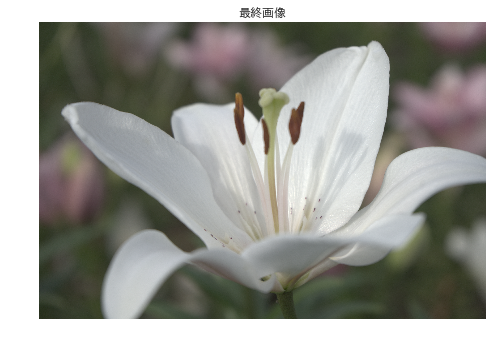

In [12]:
# 最終画像表示
plt.figure(figsize=(8, 8))
plt.imshow(shp_img)
plt.axis('off')
plt.title(u"最終画像")
plt.show()

先程のRAWPYによる現像と似た画像が得られました。

色合いが若干淡くでいてる、コントラストが違う、などの点がみられますが、このあたりはカラーマトリクスの値の変更、トーンカーブ処理などで改善できると思われます。

### まとめ

今回は市販のミラーレスカメラ、ソニーα7-IIIのRAW画像を現像してみました。

これで「PythonとColabで作る - RAW画像処理入門」の内容はすべて終わりです。おつかれさまでした。